In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm import tqdm

import networkx as nx

In [2]:
orf_info = pd.read_parquet("data/atlas_output/Genecatalog/clustering/orf_info.parquet")

In [3]:
orf_info.sort_values(["Sample","ContigNr","OrfNr"], inplace=True)
orf_info.head()

,Sample,ContigNr,OrfNr,GeneNr
524684,DY106,1,1,189119
662163,DY106,1,2,234657
1484559,DY106,1,3,533848
256704,DY106,1,4,86155
322680,DY106,1,5,109181


In [130]:
orf_info["Contig"]= pd.Categorical(orf_info["Sample"] + "_" + orf_info["ContigNr"].astype(str))


# Gene centric

In [139]:
GeneID_of_interest= 86155

In [144]:
contigs_of_gene= orf_info.loc[orf_info["GeneNr"]==GeneID_of_interest,"Contig"].unique()

In [145]:
orf_info.loc[orf_info["Contig"].isin(contigs_of_gene),:]

,Sample,ContigNr,OrfNr,GeneNr,Contig
524684,DY106,1,1,189119,DY106_1
662163,DY106,1,2,234657,DY106_1
1484559,DY106,1,3,533848,DY106_1
256704,DY106,1,4,86155,DY106_1
322680,DY106,1,5,109181,DY106_1
...,...,...,...,...,...
1484566,DY407,895,16,533848,DY407_895
662172,DY407,895,17,234657,DY407_895
881280,DY407,895,18,306069,DY407_895
540069,DY407,895,19,196623,DY407_895


# Coverage graph

In [89]:
#g= gt.Graph(directed=True)
from collections import defaultdict

gene_connections = defaultdict(int)

for index,d in tqdm(orf_info.groupby(["Sample","ContigNr"])):

    if d.shape[0]>1:

        assert d.OrfNr.is_monotonic_increasing

        for i in range(d.shape[0]-1):


            #orf_nrs = d.OrfNr.loc[pair_orf_ids].values

            #if abs(orf_nrs[1]-orf_nrs[0])==1:
                # check if adjacent orfs

            gene_nr_pair = (d.GeneNr.iloc[i],d.GeneNr.iloc[i+1])

            if gene_nr_pair[0] > gene_nr_pair[1]:
                gene_nr_pair = (gene_nr_pair[1],gene_nr_pair[0])
                
            gene_connections[gene_nr_pair] += 1

            #else:
            #    print(f"gene pair not adjacent orfs in contig  {orf_nrs}")
                

gene_connections= pd.Series(gene_connections)

100%|██████████| 256997/256997 [01:28<00:00, 2894.19it/s]


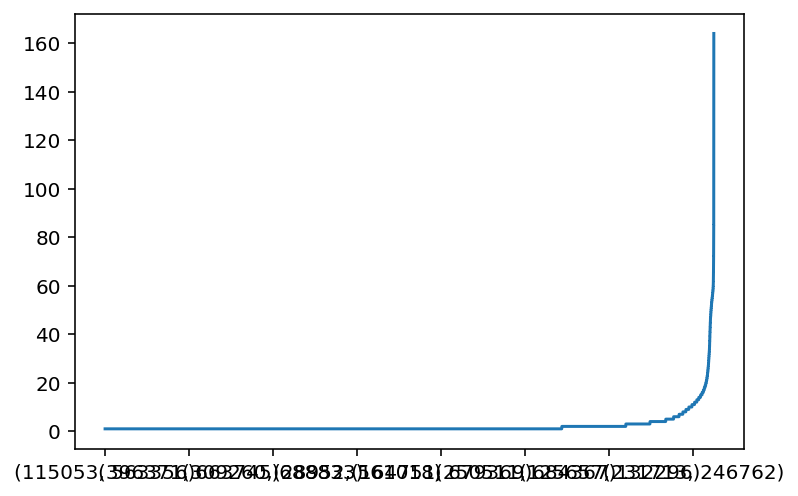

In [90]:
gene_connections.sort_values().plot()

filtered_gene_connections = gene_connections.loc[gene_connections>2]

In [91]:
filtered_gene_connections.shape[0]/ gene_connections.shape[0]

0.14465815151665756

In [92]:
filtered_gene_connections.shape

(104784,)

In [165]:
G= nx.from_edgelist(gene_connections.index,create_using=nx.Graph)

In [166]:
# add edge attribute coverate
nx.set_edge_attributes(G, gene_connections.to_dict(), 'coverage')

In [167]:
len(G)
len(G.edges)

724356

In [168]:
filtered_gene_connections

189119  234657    11
234657  533848    15
86155   533848    15
        109181    31
109181  582954     4
                  ..
5401    246002     3
72200   676605     3
455025  655071     3
604362  705582     3
81885   281020     3
Length: 104784, dtype: int64

In [178]:
neighborhood_size=5


GeneID_of_interest= 86155# 655071 #

Gneighborhood= G.subgraph( nx.single_source_shortest_path_length(G, GeneID_of_interest, cutoff=neighborhood_size).keys() )

In [179]:
len(Gneighborhood)

153

In [180]:
pos= nx.spring_layout(Gneighborhood)

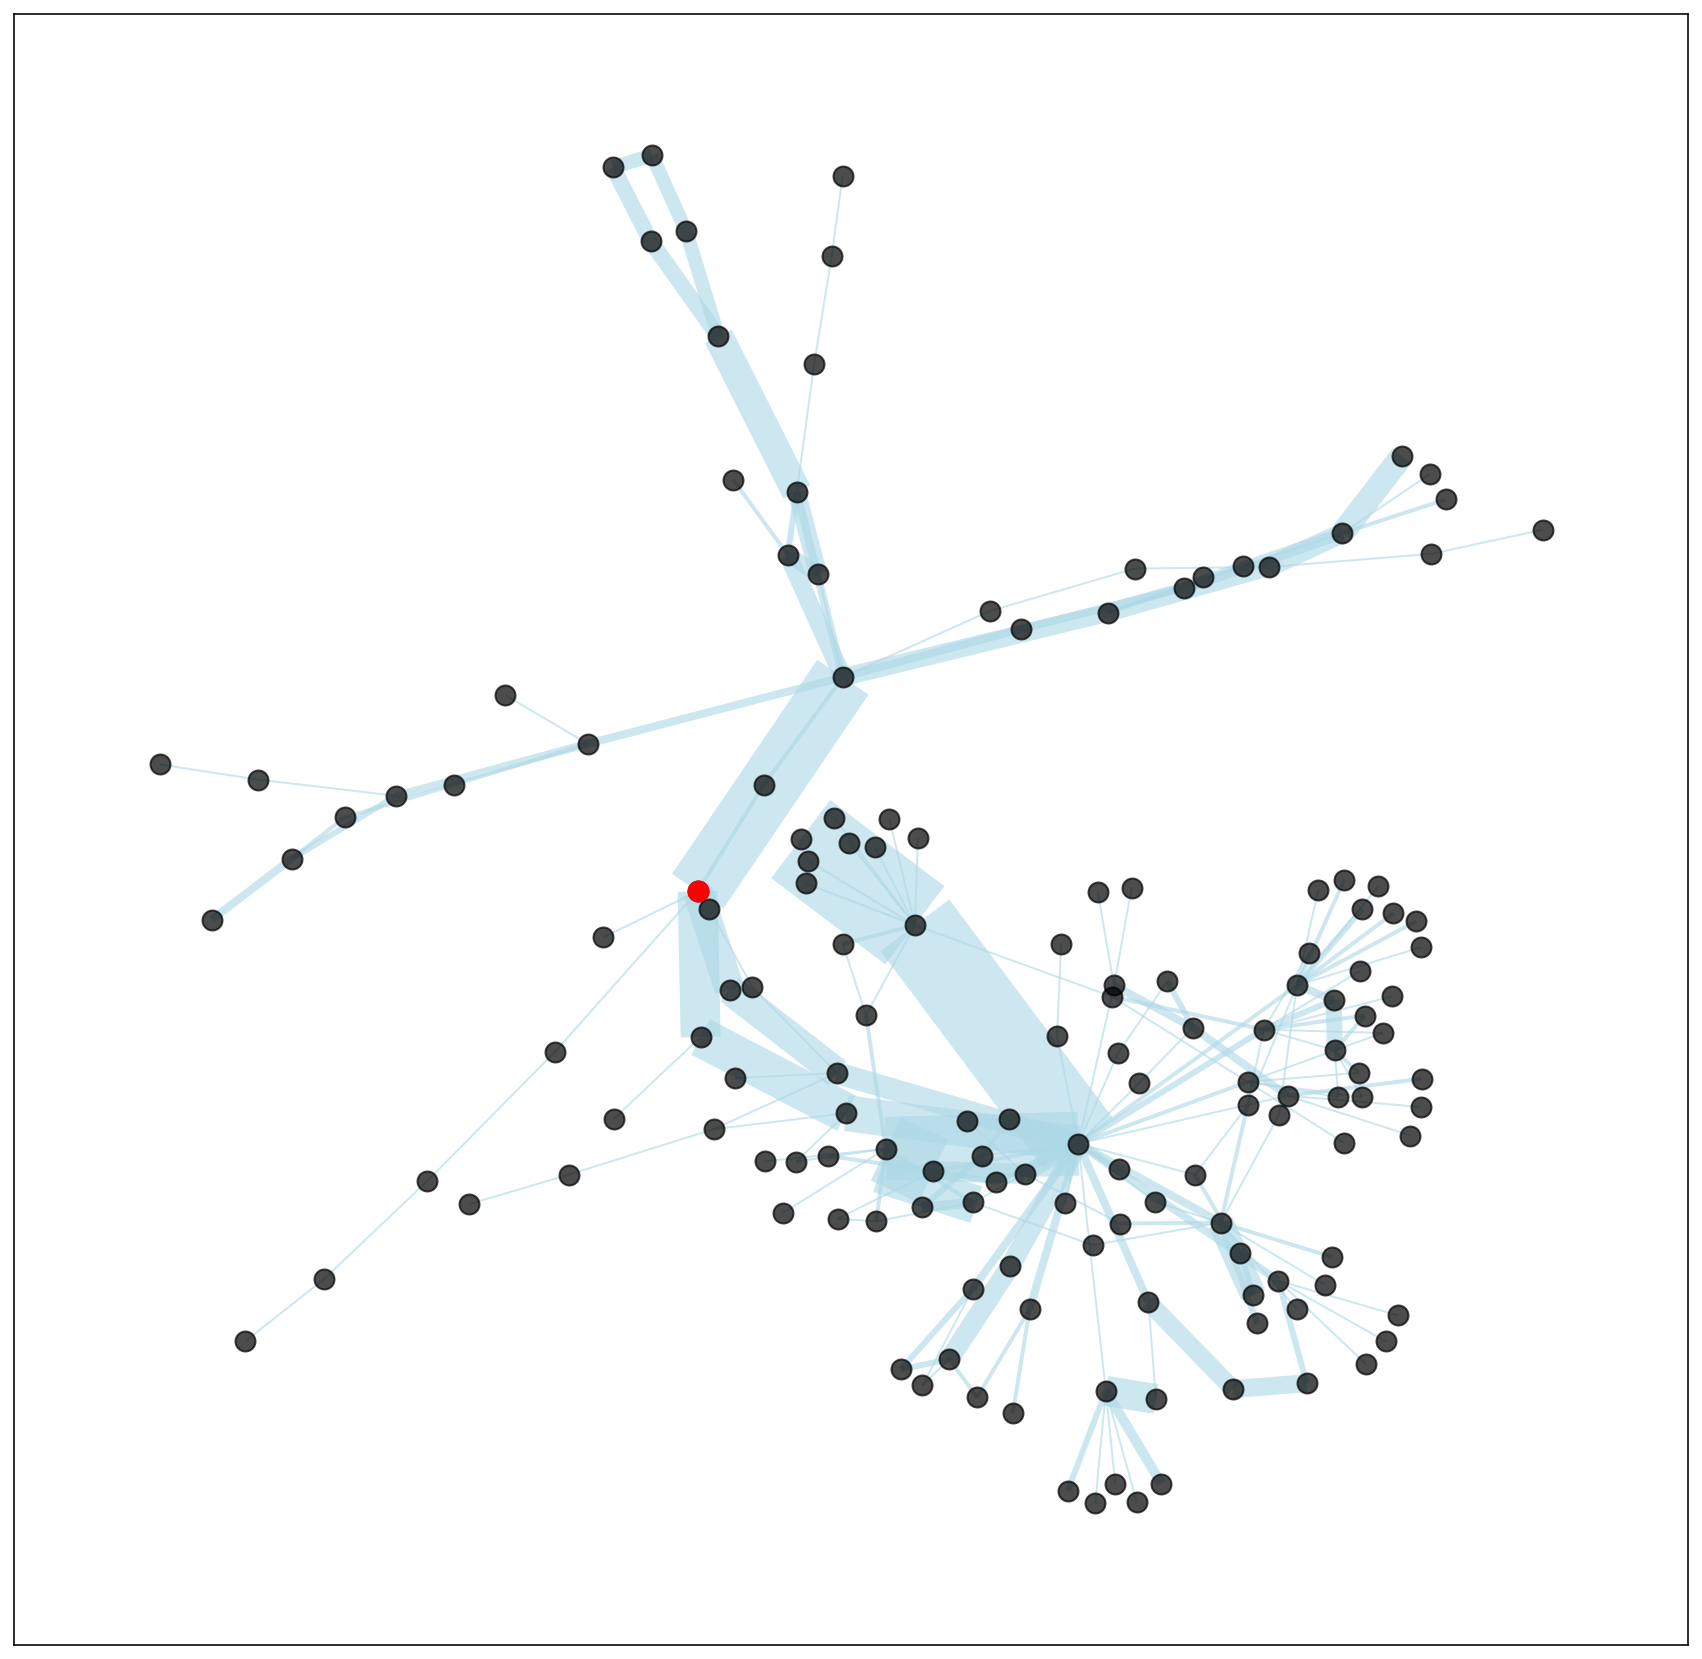

In [181]:
fig= plt.figure(figsize=(15,15))

widths = nx.get_edge_attributes(Gneighborhood, 'coverage')

nx.draw_networkx_nodes(Gneighborhood,pos,
                       node_size=100,
                       node_color='black',
                       alpha=0.7)

nx.draw_networkx_nodes(Gneighborhood,pos,
                       nodelist=[GeneID_of_interest],
                       node_size=100,
                       node_color='red',
                       alpha=1)

nx.draw_networkx_edges(Gneighborhood,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.6)


nx.draw_networkx_edges(Gneighborhood,pos,
                       width=1,
                       edge_color='darkblue',
                       alpha=0.0)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image


p=nx.drawing.nx_pydot.to_pydot(G)
if False : #higlight_node is not None:
    node_of_interest= p.get_node(str(higlight_node))[0]
    node_of_interest.set_color('red')
    node_of_interest.set_shape('box')
    
p.write_png('multi.png')
    
Image(filename='multi.png')